Task : Use the numerical approach: MEEP to reproduce T vs ω plot

----------numerical analysis----------

In [1]:
import numpy as np
#頻率相關參數
Nf = 200
fmin = 1
fmax = 5
fre = np.linspace(fmin, fmax, Nf)
fcen = (fmin+fmax)/2
df = (fmax-fmin)
omega = 2 * np.pi * fre

In [2]:
#晶體厚度
d_list = [0.167,0.056]
#材料介電常數
epsi_list = [9,80]

In [3]:
#材料相位差
delta_list = []
for epsi, d in zip(epsi_list, d_list):
    delta = 2*omega * d * np.sqrt(epsi)
    delta_list.append(delta)

In [4]:
#反射係數
r_list = []
for epsi in epsi_list:
    r = (np.sqrt(epsi) - 1)/( np.sqrt(epsi) + 1 )
    r_list.append(r)
#透射率
T_num = []
for r, delta in zip(r_list, delta_list):
    R = np.abs(r**2)
    F = 4 * R/(1 - R)**2
    T_ana = 1 / (1 + F * np.sin(delta/2)**2)
    T_num.append(T_ana)

----------meep analysis----------

In [5]:
import meep as mp
#模擬空間參數
resolution = 1000
dpml = 1.0
sz = (d_list[0] * 12.0) + (dpml * 2.0)
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]
dimensions = 1

In [6]:
#電磁波源(高斯)
sour_z = - (d_list[0]  / 2) - 0.3 
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df), component=mp.Ex, 
                     center=mp.Vector3(z=sour_z))]

In [7]:
#整體模擬流程(真空場)(0)
sim_vac = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=sources,
                        dimensions=dimensions,
                        resolution=resolution)
#數據偵測(真空場)(0)
tran_z = (d_list[0] / 2) + 0.3
tran_vac_fr = mp.FluxRegion(center=mp.Vector3(z = tran_z))
tran_vac = sim_vac.add_flux(fcen, df, Nf, tran_vac_fr)
#數據模擬(真空場)(0)
sim_vac.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=0), 1e-3))

-----------
Initializing structure...
time for choose_chunkdivision = 0.000618935 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 4.004 with resolution 1000
time for set_epsilon = 0.00115514 s
-----------
field decay(t = 50.0005): 0.24999187881573973 / 0.24999187881573973 = 1.0
on time step 180192 (time=90.096), 2.21986e-05 s/step
field decay(t = 100.0005): 1.459121613001947e-17 / 0.24999187881573973 = 5.836676054894626e-17
run 0 finished at t = 100.0005 (200001 timesteps)


In [8]:
#紀錄通量(真空場)(0)
T_vac = np.array(mp.get_fluxes(tran_vac))

In [9]:
#晶體結構(1)
geometry = []
geometry.append(mp.Block(size=mp.Vector3(mp.inf, mp.inf, d_list[0]),
                             center=mp.Vector3(z=0),
                             material=mp.Medium(epsilon=epsi_list[0])
                        )
                )

In [10]:
#整體模擬流程(結構場)(1)
sim_poyn = mp.Simulation(cell_size=cell_size,
                         geometry=geometry,
                         boundary_layers=pml_layers,
                         sources=sources,
                         dimensions=dimensions,
                         resolution=resolution)
#數據偵測(結構場)(1)
tran_z = (d_list[0] / 2) + 0.3
tran_fr = mp.FluxRegion(center=mp.Vector3(z = tran_z))
tran = sim_poyn.add_flux(fcen, df, Nf, tran_fr)
#數據模擬(結構場)(1)
sim_poyn.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=0), 1e-3))

-----------
Initializing structure...
time for choose_chunkdivision = 0.000526905 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 4.004 with resolution 1000
     block, center = (0,0,0)
          size (1e+20,1e+20,0.167)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9,9,9)
time for set_epsilon = 0.00068903 s
-----------
field decay(t = 50.0005): 0.054670587986755295 / 0.054670587986755295 = 1.0
on time step 161157 (time=80.5785), 2.48207e-05 s/step
field decay(t = 100.0005): 2.269709898818766e-15 / 0.054670587986755295 = 4.1516105503907045e-14
run 0 finished at t = 100.0005 (200001 timesteps)


In [11]:
#紀錄通量(真空場)(1)
T_str = np.array(mp.get_fluxes(tran))
T_meep_1 = T_str / T_vac

<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_4513/3643842973.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega$ ($2\pi$/μm)")


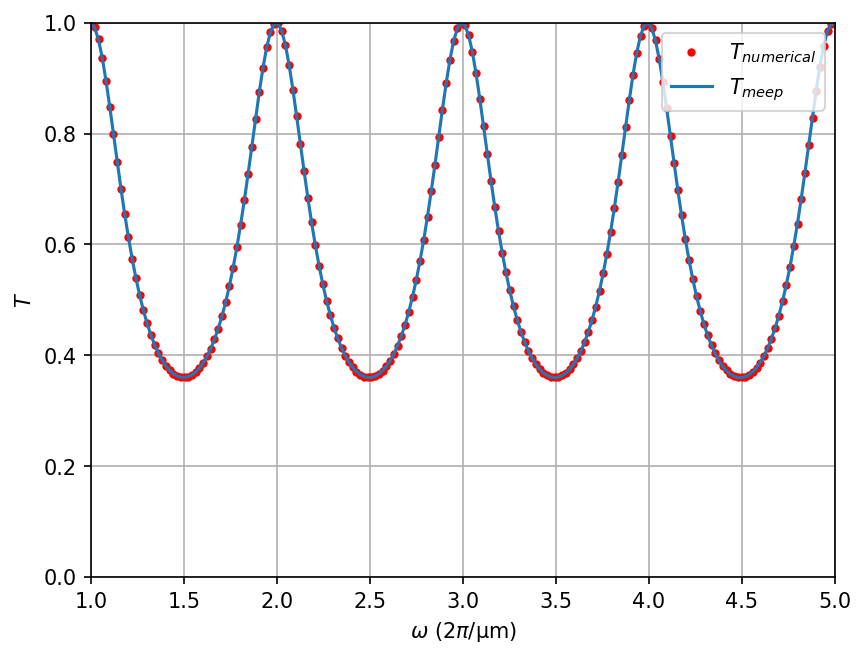

In [12]:
#繪圖比較(數值與實驗)(1)
from matplotlib import pyplot as plt 
plt.figure(dpi=150)
plt.plot(omega/2/np.pi,T_num[0],'r.',label='$T_{numerical}$')
plt.plot(omega/2/np.pi,T_meep_1,label='$T_{meep}$')
plt.xlabel("$\omega$ ($2\pi$/μm)")
plt.ylabel("$T$")
plt.legend(loc="upper right")
plt.xlim([fmin,fmax])
plt.ylim([0,1])
plt.grid()
plt.show()

In [13]:
#晶體結構(2)
geometry = []
geometry.append(mp.Block(size=mp.Vector3(mp.inf, mp.inf, d_list[1]),
                             center=mp.Vector3(z=0),
                             material=mp.Medium(epsilon=epsi_list[1])
                        )
                )

In [14]:
#整體模擬流程(結構場)(2)
sim_poyn = mp.Simulation(cell_size=cell_size,
                         geometry=geometry,
                         boundary_layers=pml_layers,
                         sources=sources,
                         dimensions=dimensions,
                         resolution=resolution)
#數據偵測(結構場)(2)
tran_z = (d_list[1] / 2) + 0.3
tran_fr = mp.FluxRegion(center=mp.Vector3(z = tran_z))
tran = sim_poyn.add_flux(fcen, df, Nf, tran_fr)
#數據模擬(結構場)(2)
sim_poyn.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=0), 1e-3))

-----------
Initializing structure...
time for choose_chunkdivision = 0.000486135 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 4.004 with resolution 1000
     block, center = (0,0,0)
          size (1e+20,1e+20,0.056)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (80,80,80)
time for set_epsilon = 0.000809193 s
-----------
field decay(t = 50.0005): 0.008248771187677334 / 0.008248771187677334 = 1.0
on time step 175586 (time=87.793), 2.2781e-05 s/step
field decay(t = 100.0005): 3.6483340324339883e-17 / 0.008248771187677334 = 4.422881844369932e-15
run 0 finished at t = 100.0005 (200001 timesteps)


In [15]:
#整體模擬流程(結構場)(2)
sim_poyn = mp.Simulation(cell_size=cell_size,
                         geometry=geometry,
                         boundary_layers=pml_layers,
                         sources=sources,
                         dimensions=dimensions,
                         resolution=resolution)
#數據偵測(結構場)(2)
tran_z = (d_list[1] / 2) + 0.3
tran_fr = mp.FluxRegion(center=mp.Vector3(z = tran_z))
tran = sim_poyn.add_flux(fcen, df, Nf, tran_fr)
#數據模擬(結構場)(2)
sim_poyn.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(z=0), 1e-3))

-----------
Initializing structure...
time for choose_chunkdivision = 0.00068593 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 4.004 with resolution 1000
     block, center = (0,0,0)
          size (1e+20,1e+20,0.056)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (80,80,80)
time for set_epsilon = 0.00114393 s
-----------
on time step 27262 (time=13.631), 0.000146984 s/step
field decay(t = 50.0005): 0.008248771187677334 / 0.008248771187677334 = 1.0
on time step 125959 (time=62.9795), 4.06243e-05 s/step
field decay(t = 100.0005): 3.6483340324339883e-17 / 0.008248771187677334 = 4.422881844369932e-15
run 0 finished at t = 100.0005 (200001 timesteps)


In [16]:
#紀錄通量(真空場)(2)
T_str = np.array(mp.get_fluxes(tran))
T_meep_1 = T_str / T_vac

<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_4513/2459123977.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega$ ($2\pi$/μm)")


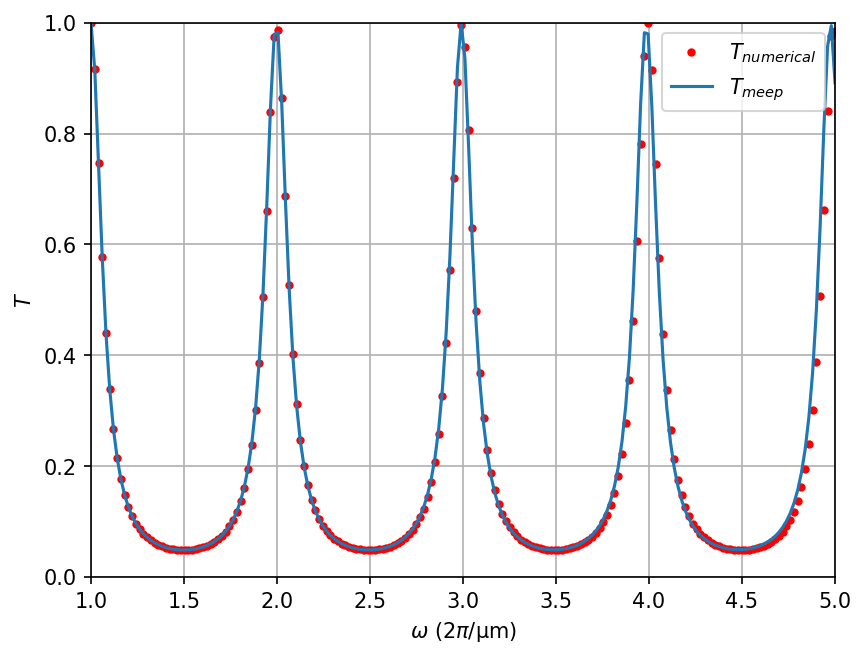

In [17]:
#繪圖比較(數值與實驗)(2)
from matplotlib import pyplot as plt 
plt.figure(dpi=150)
plt.plot(omega/2/np.pi,T_num[1],'r.',label='$T_{numerical}$')
plt.plot(omega/2/np.pi,T_meep_1,label='$T_{meep}$')
plt.xlabel("$\omega$ ($2\pi$/μm)")
plt.ylabel("$T$")
plt.legend(loc="upper right")
plt.xlim([fmin,fmax])
plt.ylim([0,1])
plt.grid()
plt.show()